In [1]:
#iomporting all required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import math
import random
import keras
import tensorflow as tf
from tqdm import tqdm
from keras.layers import Conv2D,MaxPooling2D,Dropout,Dense, Flatten,BatchNormalization,Input
from keras.layers import ZeroPadding2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import load_img,ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split


In [2]:
#reading .csv file 
dataframe = pd.read_csv('D:/deep learning/kaggle distraction dataset/state-farm-distracted-driver-detection/driver_imgs_list.csv')

dataframe.head()


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [3]:
#function to read all images in the directory
def images_data(imgs_path, img_h= None, img_w = None,grayscale = True):
    img = cv2.imread(imgs_path)
    if img_h!= None and img_w!=None :
        img = cv2.resize(img,(img_h,img_w))
        
    return img


In [4]:

n_classes = 10
#function to split data into train and test
def load_train(img_h, img_w, color_type=3):
    images = [] 
    train_labels = []
    # Loop over the training folder 
    for n in range(n_classes):
        files = glob.glob(os.path.join('D:/deep learning/kaggle distraction dataset/state-farm-distracted-driver-detection/imgs', 'train', 'c' + str(n), '*.jpg'))
        for file in files:
            img = images_data(file, img_rows, img_cols, color_type)
            images.append(img)
            train_labels.append(n)
    return images, train_labels 


In [5]:
def data_split(imgs,train_labels,split_ratio = 0.25):
    
    X_train,X_test,y_train,y_test = train_test_split(imgs,train_labels,test_size = split_ratio )
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    
    return X_train,X_test,y_train,y_test


In [6]:
#image statistics
img_rows = 256
img_cols = 256

imgs,train_labels = load_train(img_h= img_rows, img_w = img_cols)
    
X_train,X_test,y_train,y_test = data_split(imgs,train_labels,split_ratio=0.25)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('X_train Shape',X_train.shape)

X_train Shape (16818, 256, 256, 3)


In [7]:
print('X_test Shape', X_test.shape)
print('y_train Shape', y_train.shape)
print('y_test Shape' , y_test.shape)


X_test Shape (5606, 256, 256, 3)
y_train Shape (16818, 10)
y_test Shape (5606, 10)


16818


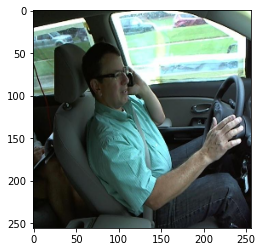

Class: talking on the phone - left


In [8]:

#data visualization
data_labels = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
               "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
               "c8": "hair and makeup", "c9": " talking to passenger"}

print(len(X_train))
random_num = random.randint(0,len(X_train))
rand_img = X_train[random_num]
img_rgb = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb,cmap=None)

data_viz_out = 'c'+str(np.argmax(y_train[random_num]))
data_viz_label = data_labels.get(data_viz_out)

plt.imshow(img_rgb)
plt.show()

print('Class: {}'.format(data_viz_label))


In [10]:
print(y_train)
print(np.argmax(y_train))

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]]
8


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

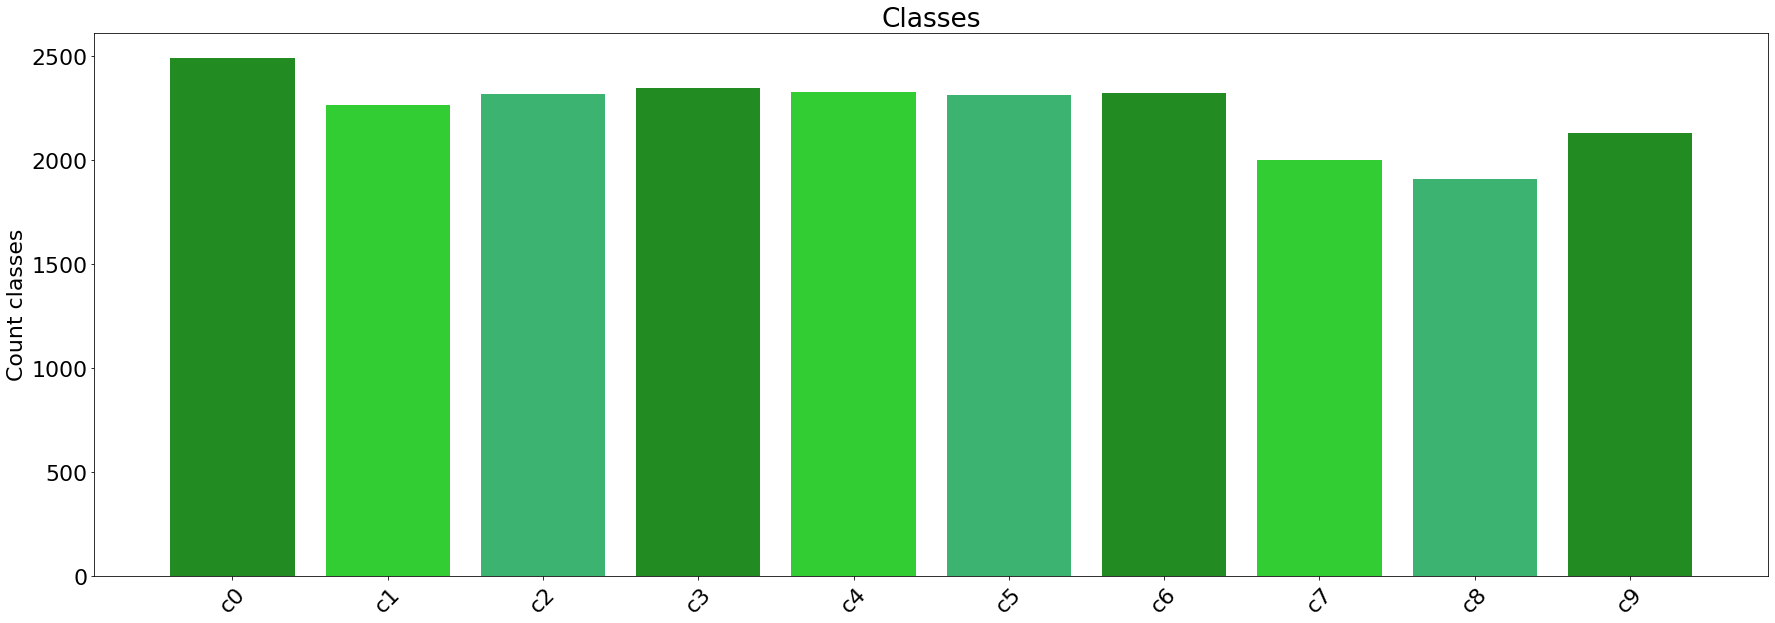

In [11]:

#data distribution
data_classes = dataframe.loc[:,['classname','img']].groupby(by='classname').count().reset_index()

data_x = list(pd.unique(dataframe['classname']))
data_y =list(data_classes['img'])

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y, color=['forestgreen', 'limegreen', 'mediumseagreen'])  
plt.ylabel('Count classes')
plt.title('Classes')
plt.xticks(rotation=45)


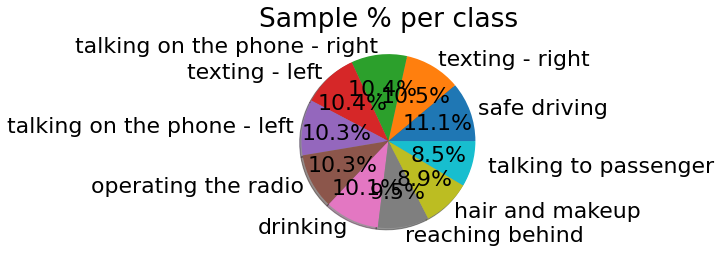

In [12]:

#plotting pie-chart

class_freq_count = dataframe.classname.value_counts()
plt.pie(class_freq_count, autopct='%1.1f%%', shadow=True, labels=data_labels.values())
plt.title('Sample % per class');
plt.show()


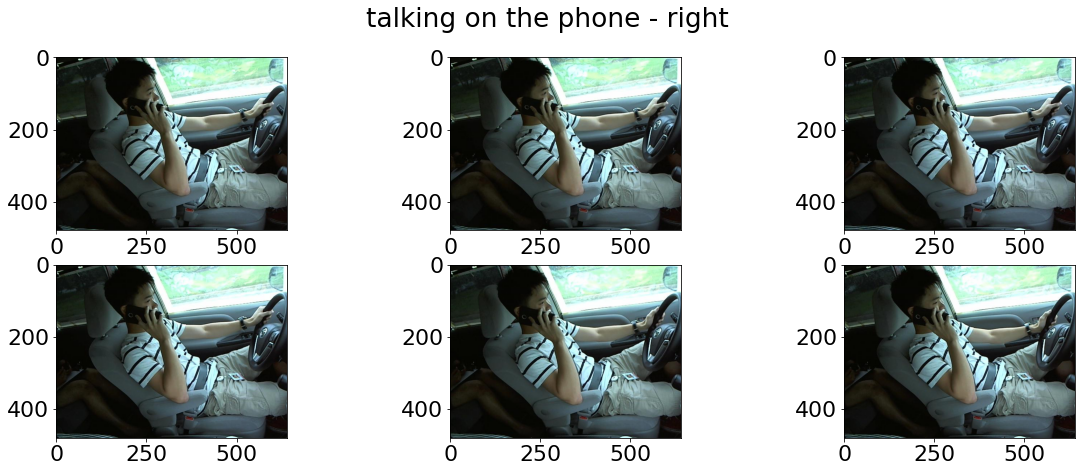

In [13]:

#plotting some images for visualization

path = 'D:/deep learning/kaggle distraction dataset/state-farm-distracted-driver-detection'
sample_train_img_dir = 'D:/deep learning/kaggle distraction dataset/state-farm-distracted-driver-detection/imgs/train'

rand_class = str(random.randint(0,9))

def plot_imgs(imgs, df, classId='c'+str(rand_class)):
    fig, axis = plt.subplots(2, 3, figsize=(20, 7))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgpath = os.path.join(path, sample_train_img_dir, f"{classId}/{row['img']}")
        row = idnx // 3
        col = idnx % 3 
        img = load_img(imgpath)
        plt.imshow(img)
        axis[row, col].imshow(img)
    plt.suptitle(data_labels[classId])
    plt.show()
    
plot_imgs(dataframe[dataframe.classname == 'c'+str(rand_class)].head(6), dataframe, classId='c'+str(rand_class))



In [14]:
#building-up the model

model = Sequential()

model.add(Conv2D(filters = 32,kernel_size=(3,3),input_shape=(256,256,3),strides = (1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding = 'same',activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(3,3),strides = (1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(3,3),strides = (1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(3,3),strides = (1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=512,kernel_size=(3,3),strides = (1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=512,kernel_size=(3,3),strides = (1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(n_classes,activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       2

In [15]:
model.compile(optimizer='Adam',loss='CategoricalCrossentropy',metrics = ['accuracy'])


In [16]:
filepath = 'D:/deep learning/kaggle distraction dataset/state-farm-distracted-driver-detection'
weight_path="D:/deep learning/kaggle distraction dataset/state-farm-distracted-driver-detection/{}dirver_distraction_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                            mode='max', save_weights_only = True)

early = EarlyStopping(monitor="accuracy", 
                      mode="max", 
                      patience=3)

In [17]:



history = model.fit(X_train,y_train,batch_size=128,epochs=10,verbose=1,callbacks = [checkpoint,early])



Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 2.3242 - accuracy: 0.1057
Epoch 00001: saving model to D:/deep learning/kaggle distraction dataset/state-farm-distracted-driver-detection/seg_modeldirver_distraction_weights.best.hdf5
132/132 [==============================] - 212s 2s/step - loss: 2.3242 - accuracy: 0.1057
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 2.3008 - accuracy: 0.1044
Epoch 00002: saving model to D:/deep learning/kaggle distraction dataset/state-farm-distracted-driver-detection/seg_modeldirver_distraction_weights.best.hdf5
132/132 [==============================] - 199s 2s/step - loss: 2.3008 - accuracy: 0.1044
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 2.2606 - accuracy: 0.1326
Epoch 00003: saving model to D:/deep learning/kaggle distraction dataset/state-farm-distracted-driver-detection/seg_modeldirver_distraction_weights.best.hdf5
132/132 [==============================] - 198s 2s/step - 

In [18]:

X_predict = []
for img in glob.glob('D:/deep learning/kaggle distraction dataset/state-farm-distracted-driver-detection/imgs/prediction/*.jpg'):
    img= cv2.imread(img)
    img = cv2.resize(img,(256,256),interpolation=cv2.INTER_AREA)
    X_predict.append(img)
    
X_predict = np.asarray(X_predict)
rand_predict = random.randint(0,len(X_predict))

print(rand_predict)

96


In [19]:
print(X_predict.shape)

(140, 256, 256, 3)


In [20]:
print(type(X_predict))

<class 'numpy.ndarray'>


In [21]:
pred = model.predict(X_predict)
pred

array([[3.3415847e-02, 9.2518572e-03, 7.1052752e-02, ..., 3.0022308e-02,
        7.2468299e-01, 5.6824494e-02],
       [8.4766209e-02, 6.5715822e-06, 3.0712215e-06, ..., 5.4110410e-06,
        3.4491858e-03, 2.1399679e-02],
       [9.2322087e-01, 1.0807572e-04, 6.3138054e-06, ..., 2.9259068e-05,
        1.2939696e-02, 4.7875911e-02],
       ...,
       [9.3930118e-02, 9.3220457e-02, 9.3707018e-02, ..., 1.8717426e-01,
        1.6239589e-01, 9.5566057e-02],
       [2.8183622e-02, 2.4515067e-08, 8.4003355e-09, ..., 1.6087251e-08,
        2.4664050e-04, 5.2733012e-03],
       [2.8068095e-02, 1.2270835e-02, 2.0604639e-01, ..., 2.5547875e-02,
        5.4670328e-01, 5.2517995e-02]], dtype=float32)

140


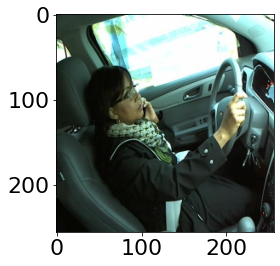

Class: talking on the phone - left


In [28]:
data_labels = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
               "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
               "c8": "hair and makeup", "c9": " talking to passenger"}

print(len(X_predict))
random_num = random.randint(0,len(X_predict))
rand_img = X_predict[random_num]
img_rgb = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb,cmap=None)

data_viz_out = 'c'+str(np.argmax(pred[random_num]))
data_viz_label = data_labels.get(data_viz_out)

plt.imshow(img_rgb)
plt.show()

print('Class: {}'.format(data_viz_label))


140


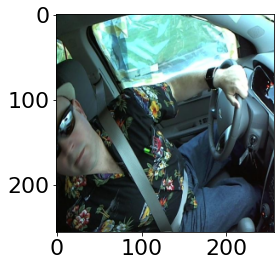

Class: reaching behind


In [29]:
data_labels = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
               "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
               "c8": "hair and makeup", "c9": " talking to passenger"}

print(len(X_predict))
random_num = random.randint(0,len(X_predict))
rand_img = X_predict[random_num]
img_rgb = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb,cmap=None)

data_viz_out = 'c'+str(np.argmax(pred[random_num]))
data_viz_label = data_labels.get(data_viz_out)

plt.imshow(img_rgb)
plt.show()

print('Class: {}'.format(data_viz_label))

140


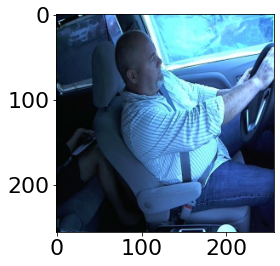

Class: hair and makeup


In [30]:
data_labels = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
               "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
               "c8": "hair and makeup", "c9": " talking to passenger"}

print(len(X_predict))
random_num = random.randint(0,len(X_predict))
rand_img = X_predict[random_num]
img_rgb = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb,cmap=None)

data_viz_out = 'c'+str(np.argmax(pred[random_num]))
data_viz_label = data_labels.get(data_viz_out)

plt.imshow(img_rgb)
plt.show()

print('Class: {}'.format(data_viz_label))

140


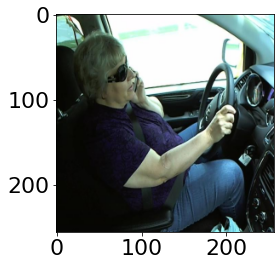

Class: talking on the phone - left


In [32]:
data_labels = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
               "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
               "c8": "hair and makeup", "c9": " talking to passenger"}

print(len(X_predict))
random_num = random.randint(0,len(X_predict))
rand_img = X_predict[random_num]
img_rgb = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb,cmap=None)

data_viz_out = 'c'+str(np.argmax(pred[random_num]))
data_viz_label = data_labels.get(data_viz_out)

plt.imshow(img_rgb)
plt.show()

print('Class: {}'.format(data_viz_label))

140


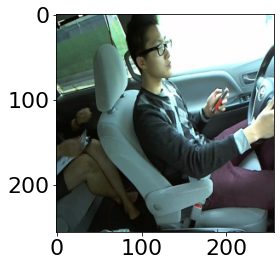

Class: texting - left


In [33]:
data_labels = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
               "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
               "c8": "hair and makeup", "c9": " talking to passenger"}

print(len(X_predict))
random_num = random.randint(0,len(X_predict))
rand_img = X_predict[random_num]
img_rgb = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb,cmap=None)

data_viz_out = 'c'+str(np.argmax(pred[random_num]))
data_viz_label = data_labels.get(data_viz_out)

plt.imshow(img_rgb)
plt.show()

print('Class: {}'.format(data_viz_label))